In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime as dt
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

### Shifting functions

In [3]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [19]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# files = ['forpr_ros3','backadm_ros3','backvs_ros3','forpr_haro3','forgulf_haro3','backvs_haro3','backadm_haro3','forgulf_ros3']
files = ['forgulf_sjc3','forpr_sjc3','backvs_sjc3','backadm_sjc3']
# files = ['foradm_haro32','foradm_ros3','foradm_sjc3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        else:
            print(name,'missing')
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc3/28may18_s1t50/ariane_positions_quantitative.nc missing


### Gulftovs_ros

In [ ]:
gulftovs_ageb = np.array(age_2018['backvs_ros3'][7])

gulftovs_ageb[np.isnan(gulftovs_ageb)] = 0

[0.05] [0.35]
0.43060277290141374


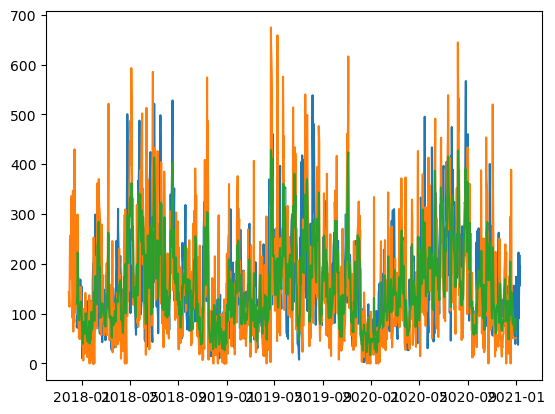

In [ ]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     

Gulftovs_rosl = sectransp_2018['forgulf_ros3'][7]
Gulftovs_rosbl = sectransp_2018['backvs_ros3'][7][0:len(datelist_vs)]

Gulftovs_ros = pd.Series(Gulftovs_rosl,index=datelist_vs)
Gulftovs_rosb = pd.Series(Gulftovs_rosbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs_ros,age_2018['forgulf_ros3'][7],datelist_vs,base,factor)
        dfr2 = shift_time(Gulftovs_rosb,gulftovs_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

Gulftovs_ros_sh = shift_time(Gulftovs_ros,age_2018['forgulf_ros3'][7],datelist_vs,base_adm[0],factor_adm[0])
Gulftovs_rosb_sh = shift_time(Gulftovs_rosb,gulftovs_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

Gulftovs_ros_m,Gulftovs_rosb_m,c,Gulftovs_ros_avg = merge(Gulftovs_ros_sh,Gulftovs_rosb_sh)
print(c)

plt.plot(Gulftovs_ros_m.Transport)
plt.plot(Gulftovs_rosb_m.Transport)
plt.plot(Gulftovs_ros_avg.dropna())

### Gulftoadm_ros

In [ ]:
gulftoadm_age = np.array(age_2018['forgulf_ros3'][2])
gulftoadm_age[np.isnan(gulftoadm_age)] = 0

gulftoadm_ageb = np.array(age_2018['backadm_ros3'][7])
gulftoadm_ageb[np.isnan(gulftoadm_ageb)] = 0

[-0.4] [0.05]
0.24594748282887885


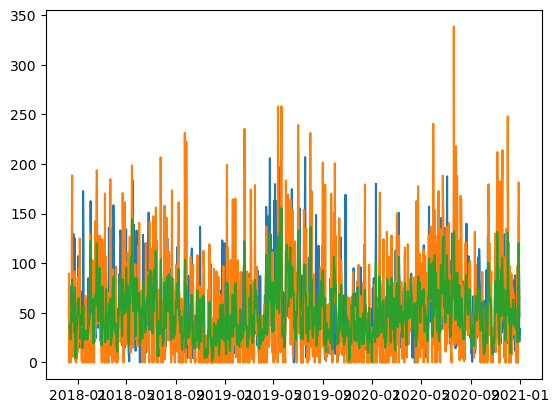

In [ ]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     

Gulftoadm_rosl = sectransp_2018['forgulf_ros3'][2]
Gulftoadm_rosbl = sectransp_2018['backadm_ros3'][7][0:len(datelist_vs)]

Gulftoadm_ros = pd.Series(Gulftoadm_rosl,index=datelist_vs)
Gulftoadm_rosb = pd.Series(Gulftoadm_rosbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftoadm_ros,gulftoadm_age,datelist_vs,base,factor)
        dfr2 = shift_time(Gulftoadm_rosb,gulftoadm_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

Gulftoadm_ros_sh = shift_time(Gulftoadm_ros,gulftoadm_age,datelist_vs,base_adm[0],factor_adm[0])
Gulftoadm_rosb_sh = shift_time(Gulftoadm_rosb,gulftoadm_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

Gulftoadm_ros_m,Gulftoadm_rosb_m,c,Gulftoadm_ros_avg = merge(Gulftoadm_ros_sh,Gulftoadm_rosb_sh)
print(c)

plt.plot(Gulftoadm_ros_m.Transport)
plt.plot(Gulftoadm_rosb_m.Transport)
plt.plot(Gulftoadm_ros_avg.dropna())

### PRtoadm_haro

In [ ]:
prtoadm_age = np.array(age_2018['forpr_haro3'][2])
prtoadm_age[np.isnan(prtoadm_age)] = 0

# prtoadm_ageb = np.array(age_2018['backadm_ros3'][7])
# prtoadm_ageb[np.isnan(prtoadm_ageb)] = 0

[-0.5] [0.4]
0.4385369091572907


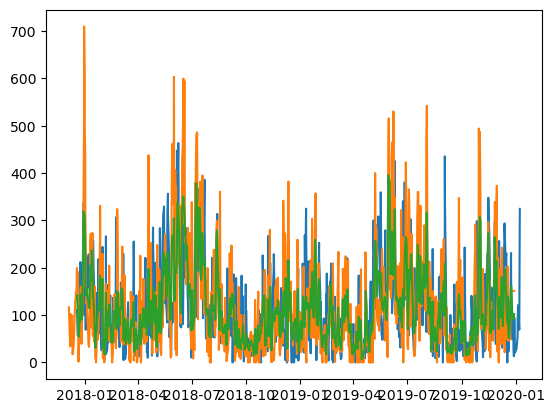

In [ ]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2019,12,29)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     

PRtoadm_harol = sectransp_2018['forpr_haro3'][2][0:len(datelist_vs)]
PRtoadm_harobl = sectransp_2018['backadm_haro3'][6]

PRtoadm_haro = pd.Series(PRtoadm_harol,index=datelist_vs)
PRtoadm_harob = pd.Series(PRtoadm_harobl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_haro,prtoadm_age,datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_harob,age_2018['backvs_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtoadm_haro_sh = shift_time(PRtoadm_haro,prtoadm_age,datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_harob_sh = shift_time(PRtoadm_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_haro_m,PRtoadm_harob_m,c,PRtoadm_haro_avg = merge(PRtoadm_haro_sh,PRtoadm_harob_sh)
print(c)

plt.plot(PRtoadm_haro_m.Transport)
plt.plot(PRtoadm_harob_m.Transport)
plt.plot(PRtoadm_haro_avg.dropna())

### Gulftoadm_haro

In [ ]:
gulftoadm_age = np.array(age_2018['forgulf_haro3'][2])
gulftoadm_age[np.isnan(gulftoadm_age)] = 0

gulftoadm_ageb = np.array(age_2018['backadm_haro3'][7])
gulftoadm_ageb[np.isnan(gulftoadm_ageb)] = 0

[-0.05] [0.45]
0.33988937790180757


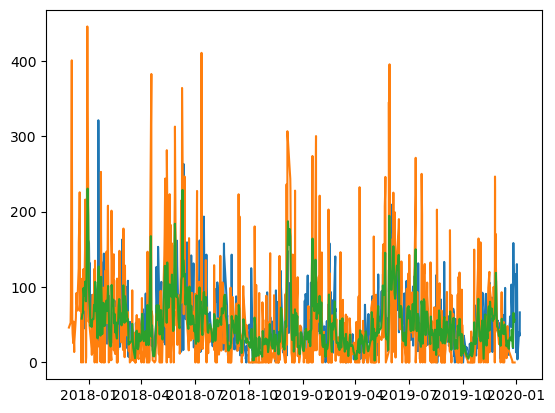

In [ ]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2019,12,29)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     

Gulftoadm_harol = sectransp_2018['forgulf_haro3'][2][0:len(datelist_vs)]
Gulftoadm_harobl = sectransp_2018['backadm_haro3'][7]

Gulftoadm_haro = pd.Series(Gulftoadm_harol,index=datelist_vs)
Gulftoadm_harob = pd.Series(Gulftoadm_harobl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftoadm_haro,gulftoadm_age,datelist_vs,base,factor)
        dfr2 = shift_time(Gulftoadm_harob,gulftoadm_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

Gulftoadm_haro_sh = shift_time(Gulftoadm_haro,gulftoadm_age,datelist_vs,base_adm[0],factor_adm[0])
Gulftoadm_harob_sh = shift_time(Gulftoadm_harob,gulftoadm_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

Gulftoadm_haro_m,Gulftoadm_harob_m,c,Gulftoadm_haro_avg = merge(Gulftoadm_haro_sh,Gulftoadm_harob_sh)
print(c)

plt.plot(Gulftoadm_haro_m.Transport)
plt.plot(Gulftoadm_harob_m.Transport)
plt.plot(Gulftoadm_haro_avg.dropna())

### SJC

### Gulftoadm_sjc

In [20]:
gulftoadm_age = np.array(age_2018['forgulf_sjc3'][2])
gulftoadm_age[np.isnan(gulftoadm_age)] = 0

gulftoadm_ageb = np.array(age_2018['backadm_sjc3'][7])
gulftoadm_ageb[np.isnan(gulftoadm_ageb)] = 0

[0.5] [-0.65]
0.17449480325727057


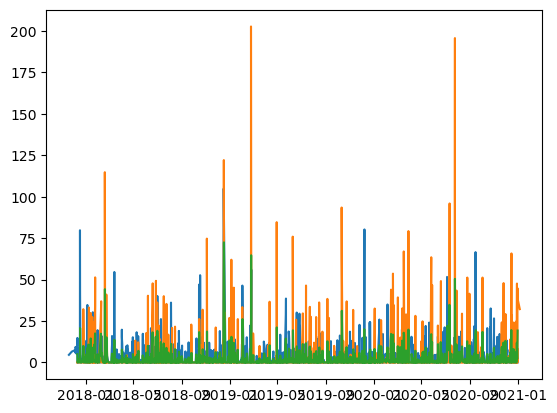

In [21]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     

Gulftoadm_sjcl = sectransp_2018['forgulf_sjc3'][2]
Gulftoadm_sjcbl = sectransp_2018['backadm_sjc3'][7]

Gulftoadm_sjc = pd.Series(Gulftoadm_sjcl,index=datelist_vs)
Gulftoadm_sjcb = pd.Series(Gulftoadm_sjcbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftoadm_sjc,gulftoadm_age,datelist_vs,base,factor)
        dfr2 = shift_time(Gulftoadm_sjcb,gulftoadm_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

Gulftoadm_sjc_sh = shift_time(Gulftoadm_sjc,gulftoadm_age,datelist_vs,base_adm[0],factor_adm[0])
Gulftoadm_sjcb_sh = shift_time(Gulftoadm_sjcb,gulftoadm_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

Gulftoadm_sjc_m,Gulftoadm_sjcb_m,c,Gulftoadm_sjc_avg = merge(Gulftoadm_sjc_sh,Gulftoadm_sjcb_sh)
print(c)

plt.plot(Gulftoadm_sjc_m.Transport)
plt.plot(Gulftoadm_sjcb_m.Transport)
plt.plot(Gulftoadm_sjc_avg.dropna())

### Gulftovs_sjc

In [10]:
gulftovs_age = np.array(age_2018['forgulf_sjc3'][7])
gulftovs_age[np.isnan(gulftovs_age)] = 0

gulftovs_ageb = np.array(age_2018['backvs_sjc3'][7])
gulftovs_ageb[np.isnan(gulftovs_ageb)] = 0

[0.95] [0.35]
0.4284580436683344


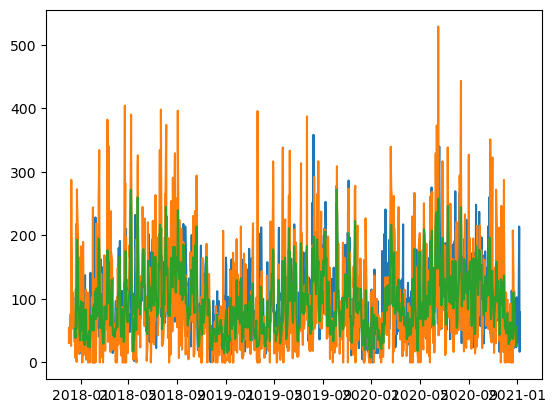

In [17]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     

Gulftovs_sjcl = sectransp_2018['forgulf_sjc3'][7]
Gulftovs_sjcbl = sectransp_2018['backvs_sjc3'][7]

Gulftovs_sjc = pd.Series(Gulftovs_sjcl,index=datelist_vs)
Gulftovs_sjcb = pd.Series(Gulftovs_sjcbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs_sjc,gulftovs_age,datelist_vs,base,factor)
        dfr2 = shift_time(Gulftovs_sjcb,gulftovs_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

Gulftovs_sjc_sh = shift_time(Gulftovs_sjc,gulftovs_age,datelist_vs,base_adm[0],factor_adm[0])
Gulftovs_sjcb_sh = shift_time(Gulftovs_sjcb,gulftovs_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

Gulftovs_sjc_m,Gulftovs_sjcb_m,c,Gulftovs_sjc_avg = merge(Gulftovs_sjc_sh,Gulftovs_sjcb_sh)
print(c)

plt.plot(Gulftovs_sjc_m.Transport)
plt.plot(Gulftovs_sjcb_m.Transport)
plt.plot(Gulftovs_sjc_avg.dropna())

### PRtovs_sjc

In [12]:
prtovs_age = np.array(age_2018['forpr_sjc3'][5])
prtovs_age[np.isnan(prtovs_age)] = 0

prtovs_ageb = np.array(age_2018['backvs_sjc3'][5])
prtovs_ageb[np.isnan(prtovs_ageb)] = 0

In [13]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs_fpr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs_fpr.append(date)
    date+=dt.timedelta(days=1)
    
datelist_vs_fpr.pop(169) #removing 28may18

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)

[-0.35] [0.35]
0.7547836661390995


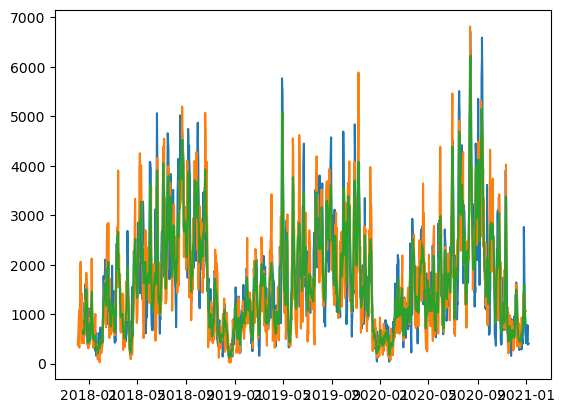

In [14]:
PRtovs_sjcl = sectransp_2018['forpr_sjc3'][5]
PRtovs_sjcbl = sectransp_2018['backvs_sjc3'][5]

PRtovs_sjc = pd.Series(PRtovs_sjcl,index=datelist_vs_fpr)
PRtovs_sjcb = pd.Series(PRtovs_sjcbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_sjc,prtovs_age,datelist_vs_fpr,base,factor)
        dfr2 = shift_time(PRtovs_sjcb,prtovs_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        # if corr_arr[i,j] > 0.65:
        #     print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtovs_sjc_sh = shift_time(PRtovs_sjc,prtovs_age,datelist_vs_fpr,base_adm[0],factor_adm[0])
PRtovs_sjcb_sh = shift_time(PRtovs_sjcb,prtovs_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_sjc_m,PRtovs_sjcb_m,c,PRtovs_sjc_avg = merge(PRtovs_sjc_sh,PRtovs_sjcb_sh)
print(c)

plt.plot(PRtovs_sjc_m.Transport)
plt.plot(PRtovs_sjcb_m.Transport)
plt.plot(PRtovs_sjc_avg.dropna())

### PRtoadm_sjc

In [22]:
prtoadm_age = np.array(age_2018['forpr_sjc3'][2])
prtoadm_age[np.isnan(prtoadm_age)] = 0

prtoadm_ageb = np.array(age_2018['backadm_sjc3'][5])
prtoadm_ageb[np.isnan(prtoadm_ageb)] = 0

[0.5] [0.3]
0.27211842165621836


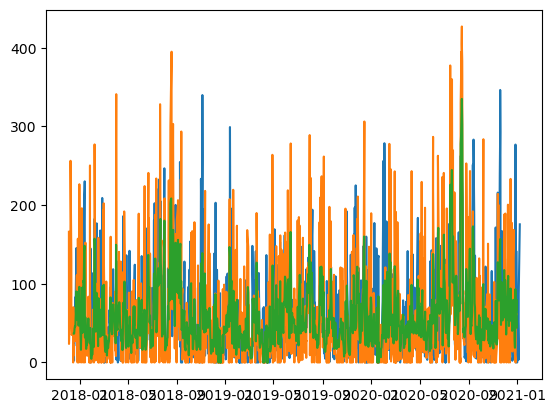

In [24]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
    
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,31)

dates = []
datelist_vs_fpr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs_fpr.append(date)
    date+=dt.timedelta(days=1)
     
datelist_vs_fpr.pop(169)

PRtoadm_sjcl = sectransp_2018['forpr_sjc3'][2][0:len(datelist_vs_fpr)]
PRtoadm_sjcbl = sectransp_2018['backadm_sjc3'][5]

PRtoadm_sjc = pd.Series(PRtoadm_sjcl,index=datelist_vs_fpr)
PRtoadm_sjcb = pd.Series(PRtoadm_sjcbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_sjc,prtoadm_age,datelist_vs_fpr,base,factor)
        dfr2 = shift_time(PRtoadm_sjcb,prtoadm_ageb,datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtoadm_sjc_sh = shift_time(PRtoadm_sjc,prtoadm_age,datelist_vs_fpr,base_adm[0],factor_adm[0])
PRtoadm_sjcb_sh = shift_time(PRtoadm_sjcb,prtoadm_ageb,datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_sjc_m,PRtoadm_sjcb_m,c,PRtoadm_sjc_avg = merge(PRtoadm_sjc_sh,PRtoadm_sjcb_sh)
print(c)

plt.plot(PRtoadm_sjc_m.Transport)
plt.plot(PRtoadm_sjcb_m.Transport)
plt.plot(PRtoadm_sjc_avg.dropna())

### North

In [17]:
admtopr_haro = pd.Series(sectransp_2018['foradm_haro32'][6],index=datelist_vs[22:])
admtopr_haro.name = 'Transport'

2018-01-01    1661.736827
2018-01-02    2780.685376
2018-01-03    2546.294598
2018-01-04    1382.567183
2018-01-05    1681.834215
                 ...     
2018-12-27    1918.982364
2018-12-28     986.504969
2018-12-29     842.956125
2018-12-30    1129.044222
2018-12-31    1083.734900
Name: Transport, Length: 365, dtype: float64

In [19]:
admtopr_ros = pd.Series(sectransp_2018['foradm_ros3'][4],index=datelist_vs)
admtopr_ros.name = 'Transport'
admtopr_ros

2017-12-10     19.194500
2017-12-11      0.000000
2017-12-12      0.000000
2017-12-13     25.908052
2017-12-14     74.062152
                 ...    
2018-12-27    247.931963
2018-12-28    145.948311
2018-12-29     26.453447
2018-12-30     26.559893
2018-12-31     28.719345
Name: Transport, Length: 387, dtype: float64

In [25]:
# Gulftovs_ros_avg.dropna().to_csv('combined2timeseries/Gulftovs_ros_avg.csv',index_label='Date')
# Gulftoadm_ros_avg.dropna().to_csv('combined2timeseries/Gulftoadm_ros_avg.csv',index_label='Date')
# PRtoadm_haro_avg.dropna().to_csv('combined2timeseries/PRtoadm_haro_avg.csv',index_label='Date')
# Gulftoadm_haro_avg.dropna().to_csv('combined2timeseries/Gulftoadm_haro_avg.csv',index_label='Date')
# Gulftoadm_sjc_avg.dropna().to_csv('combined2timeseries/Gulftoadm_sjc_avg.csv',index_label='Date')
# Gulftovs_sjc_avg.dropna().to_csv('combined2timeseries/Gulftovs_sjc_avg.csv',index_label='Date')
# PRtovs_sjc_avg.dropna().to_csv('combined2timeseries/PRtovs_sjc_avg.csv',index_label='Date')
# Gulftoadm_sjc_avg.dropna().to_csv('combined2timeseries/Gulftoadm_sjc_avg.csv',index_label='Date')
# admtopr_haro.dropna().to_csv('combined2timeseries/admtopr_haro.csv',index_label='Date')
# PRtoadm_sjc_avg.dropna().to_csv('combined2timeseries/PRtoadm_sjc_avg.csv',index_label='Date')
# admtopr_ros.dropna().to_csv('combined2timeseries/admtopr_ros.csv',index_label='Date')